### Student Information
Name: 彭星樺

Student ID: 113065507

GitHub ID: ktpss97094

Kaggle name: ktpss97094

Kaggle private scoreboard snapshot:
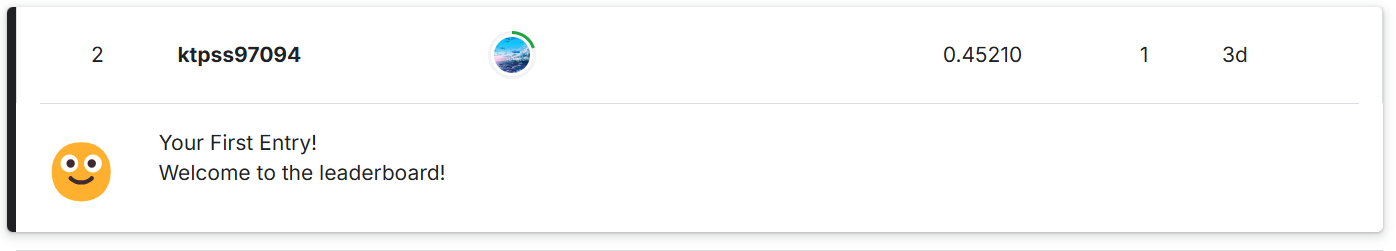

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home exercises** in the [DM2024-Lab2-master Repo](https://github.com/didiersalazar/DM2024-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework) regarding Emotion Recognition on Twitter by this link: https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework. The scoring will be given according to your place in the Private Leaderboard ranking:
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (0.6N + 1 - x) / (0.6N) * 10 + 20 points, where N is the total number of participants, and x is your rank. (ie. If there are 100 participants and you rank 3rd your score will be (0.6 * 100 + 1 - 3) / (0.6 * 100) * 10 + 20 = 29.67% out of 30%.)   
    Submit your last submission **BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)**. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developing the model for the competition (You can use code and comment on it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)__. 

## config

In [1]:
!pip install transformers[torch] datasets accelerate -U

In [9]:
### Begin Assignment Here
import os
from enum import Enum
import copy
import torch
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
import string
from nltk.stem.porter import PorterStemmer
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, pipeline
import torch
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
from datasets import Dataset
import numpy as np

class EXEC_ENV_ENUM(Enum):
    COLAB = 1
    KAGGLE = 2
    LOCAL = 3

'''
parameters
'''
# EXEC_ENV = EXEC_ENV_ENUM.COLAB
# EXEC_ENV = EXEC_ENV_ENUM.KAGGLE
EXEC_ENV = EXEC_ENV_ENUM.LOCAL
FROM_CHECKPOINT = True
TRAIN = False

input_path = ""
if EXEC_ENV == EXEC_ENV_ENUM.COLAB:
    from google.colab import drive
    drive.mount("/content/gdrive")
    input_path = "/content/gdrive/MyDrive/DMLab2/DM2024-Lab2-Homework"
elif EXEC_ENV == EXEC_ENV_ENUM.KAGGLE:
    input_path = "/kaggle/input/dm-2024-isa-5810-lab-2-homework"
    os.chdir("/kaggle/working")
else:
    input_path = "."
if FROM_CHECKPOINT:
    model_ckpt = os.path.join(input_path, "checkpoint", "best")
else:
    model_ckpt = "distilbert-base-uncased"

SEED = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EMOTIONS = ["anger", "anticipation", "disgust", "fear", "sadness", "surprise", "trust", "joy"]
NUM_EMOTIONS = len(EMOTIONS)
ID_TO_EMOTIONS = {str(index): emotion for index, emotion in enumerate(EMOTIONS)}
EMOTIONS_TO_ID = {emotion: index for index, emotion in enumerate(EMOTIONS)}

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ktpss\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
def remove_stopwords(text: str) -> str:
    '''
    E.g.,
        text: 'Here is a dog.'
        preprocessed_text: 'Here dog.'
    '''
    stop_word_list = stopwords.words('english')
    tokenizer = ToktokTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token.lower() not in stop_word_list]
    preprocessed_text = ' '.join(filtered_tokens)

    return preprocessed_text


def preprocessing_function(text: str) -> str:
    preprocessed_text = remove_stopwords(text)

    # 轉小寫
    preprocessed_text = preprocessed_text.lower()

    # 移除無用字元
    preprocessed_text = preprocessed_text.replace('<LH>', ' ').replace('<lh>', ' ')

    # 移除 tag (@) 人
    preprocessed_text = re.sub(r"@\w+\s*", "", preprocessed_text)

    # 移除punctuation
    preprocessed_text = "".join([char for char in preprocessed_text if char not in string.punctuation])

    # stemming
    stemmer = PorterStemmer()
    tokenizer = ToktokTokenizer()
    tokens = tokenizer.tokenize(preprocessed_text)
    stemming_tokens = [stemmer.stem(token) for token in tokens]
    preprocessed_text = ' '.join(stemming_tokens)

    return preprocessed_text

def tokenize(batch, tokenizer):
    return tokenizer(batch["text"], padding=True, truncation=True)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

def draw_plot(log_history):
    training_loss = []
    validation_loss = []
    for log in log_history:
        if "loss" in log:
            training_loss.append(log["loss"])
        if "eval_loss" in log:
            validation_loss.append(log["eval_loss"])

    plt.figure(figsize=(10, 6))
    plt.plot(training_loss, label="Training Loss")
    plt.plot(validation_loss, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.xticks(range(1, len(training_loss) + 1))  # x 軸從 1 開始
    plt.savefig(os.path.join(input_path, 'loss_plot.png'))
    plt.show()

## Preprocessing

In [5]:
preprocessing_train_path = os.path.join(input_path, "preprocessing_train.parquet")
preprocessing_test_path = os.path.join(input_path, "preprocessing_test.parquet")

distilbert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

if os.path.exists(preprocessing_train_path) and os.path.exists(preprocessing_test_path):
    train = pd.read_parquet(preprocessing_train_path)
    test = pd.read_parquet(preprocessing_test_path)
else:
    df = pd.read_json(os.path.join(input_path, "tweets_DM.json"), lines=True)

    # 取出 _source 中的資料
    df["hashtags"] = df["_source"].apply(lambda x: x["tweet"]["hashtags"])
    df["tweet_id"] = df["_source"].apply(lambda x: x["tweet"]["tweet_id"])
    df["text"] = df["_source"].apply(lambda x: x["tweet"]["text"])

    # 將 tweet_id 移到第一個 column
    cols = list(df.columns)
    cols.insert(0, cols.pop(cols.index('tweet_id')))
    df = df[cols]

    # 移除無用 columns
    df = df.drop(columns=["_index", "_crawldate", "_type", "_source"], errors="ignore")

    # 匯入 emotion
    df = df.merge(pd.read_csv(os.path.join(input_path, "emotion.csv")), on="tweet_id", how="left")

    # 分離 train set / test set
    df = df.merge(pd.read_csv(os.path.join(input_path, "data_identification.csv")), on="tweet_id", how="left")
    train = df[df["identification"] == "train"]
    test = df[df["identification"] == "test"]
    train = train.drop(columns=["identification"], errors="ignore")
    test = test.drop(columns=["identification"], errors="ignore")

    # 將 emotion label 編號
    train['label'] = train['emotion'].map(EMOTIONS_TO_ID)
    test['label'] = EMOTIONS_TO_ID["surprise"]  # 隨便一個在範圍內的

    # 做 text 的 preprocessing
    train.loc[:, "text"] = train.loc[:, "text"].apply(preprocessing_function)
    test.loc[:, "text"] = test.loc[:, "text"].apply(preprocessing_function)

    # 用 Distilbert 對 text 做 encode
    train_encoded = train.apply(tokenize, args=(distilbert_tokenizer,), axis=1)
    train['input_ids'] = train_encoded.apply(lambda x: x["input_ids"])
    train['attention_mask'] = train_encoded.apply(lambda x: x["attention_mask"])
    test_encoded = test.apply(tokenize, args=(distilbert_tokenizer,), axis=1)
    test['input_ids'] = test_encoded.apply(lambda x: x["input_ids"])
    test['attention_mask'] = test_encoded.apply(lambda x: x["attention_mask"])

    # 儲存
    train.to_parquet(preprocessing_train_path)
    test.to_parquet(preprocessing_test_path)

# train 時要保留 4 個 column
train = train[['text', 'label', 'input_ids', 'attention_mask']]
test_tweet_id = test["tweet_id"]
test = test[['text', 'label', 'input_ids', 'attention_mask']]

# train set 分割出 validation set
train, validation = train_test_split(train, test_size=0.05, random_state=SEED)

# 轉換為 Hugging Face Dataset
train = Dataset.from_pandas(train)
validation = Dataset.from_pandas(validation)
test = Dataset.from_pandas(test)

## Fine-Tune

C:\Users\ktpss\AppData\Local\Temp\ipykernel_12396\3020110145.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(model_ckpt, "optimizer.pt"), map_loc

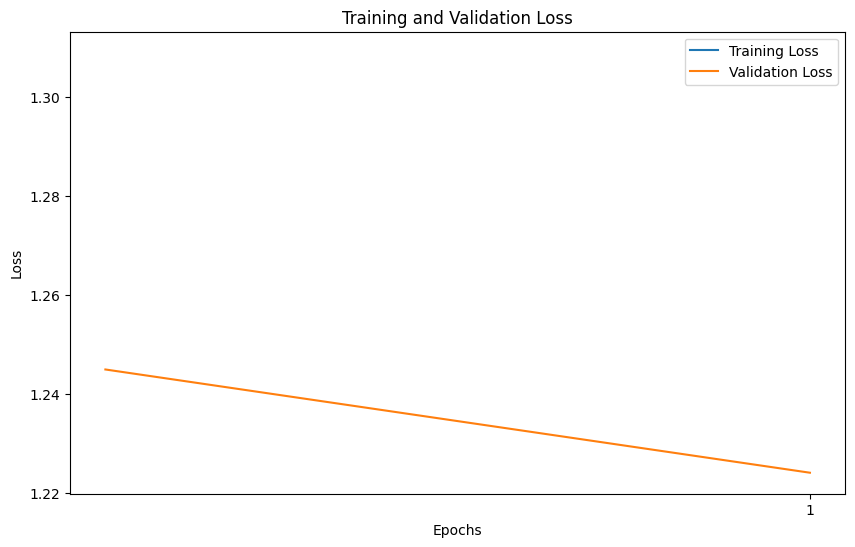

In [16]:
other_TrainingArguments_args, other_Trainer_args = dict(), dict()

if FROM_CHECKPOINT:
    other_TrainingArguments_args = {"resume_from_checkpoint": model_ckpt}
    other_Trainer_args = {"optimizers": (
                  torch.load(os.path.join(model_ckpt, "optimizer.pt"), map_location=device),
                  torch.load(os.path.join(model_ckpt, "scheduler.pt"), map_location=device)
                  )}

model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=NUM_EMOTIONS, id2label=ID_TO_EMOTIONS, label2id=EMOTIONS_TO_ID)
         .to(device))

batch_size = 64
logging_steps = len(train) // batch_size
model_output_dir = os.path.join(input_path, "checkpoint")
training_args = TrainingArguments(output_dir=model_output_dir,
                                num_train_epochs=10,
                                learning_rate=2e-5,
                                per_device_train_batch_size=batch_size,
                                per_device_eval_batch_size=batch_size,
                                weight_decay=0.01,
                                evaluation_strategy="epoch",
                                disable_tqdm=False,
                                logging_steps=logging_steps,
                                log_level="error",
                                save_strategy="epoch",
                                **other_TrainingArguments_args)

trainer = Trainer(model=model, args=training_args,
                compute_metrics=compute_metrics,
                train_dataset=train,
                eval_dataset=validation,
                tokenizer=distilbert_tokenizer,
                **other_Trainer_args)

if TRAIN:
    trainer.train()

    draw_plot(trainer.state.log_history)

    validate_pred = trainer.predict(validation)

    display(validate_pred)

# test_pred = trainer.predict(test)
import json
state_file = os.path.join(model_ckpt, "trainer_state.json")
with open(state_file, 'r') as f:
    trainer_state = json.load(f)
trainer.state.log_history = trainer_state["log_history"]
draw_plot(trainer.state.log_history)

## Output

In [ ]:
test_pred_label = np.argmax(test_pred.predictions, axis=1)
test_id_label_df = pd.concat([test_tweet_id.rename("id").reset_index(drop=True), pd.DataFrame([ID_TO_EMOTIONS[str(i)] for i in test_pred_label], columns=['emotion'])], axis=1)
sample = pd.read_csv(os.path.join(input_path, "sampleSubmission.csv"))
submission = pd.merge(sample["id"], test_id_label_df, on=["id"])
submission.to_csv(os.path.join(model_output_dir, 'submission.csv'), index=False)

submission

# Report

## Preprocessing

1. Read the `tweets_DM.json` file into the main train and test dataframe.
2. Extract the data in the `_source` field of `tweets_DM.json` into three separate rows: `hashtags`, `tweet_id`, and `text`
3. Remove the `_index`, `_crawldate`, `_type` and `_source` columns as I found that `_index` and `_type` were the same for all data and the crawl date for tweets is irrelevant.
4. Merge the data from `emotion.csv` into the main dataframe
5. split the dataframe into train dataframe and test dataframe according to `data_identification.csv`
6. Numbering the emotion string (add column `label`)
7. Tweet text:
    * Remove stopwords
    * Change all letters to lowercase
    * Since tweets often have tag (@) and the tagged text is just a username on twitter, I think it's irrelevant, so I remove it.
    * Remove punctuation (```!"). #$%&\'()*+,-. /:;<=>? @[\\\]^_`{|}~```)
    * stemming
8. Feature Creation: Encode text using HuggingFace's Distilbert.

In the end, only the columns `text`, `label`, `input_ids` and `attention_mask` will be kept for training.

## Model

### Introduction

The model I use is HuggingFace's Distilbert (distilbert-base-uncased)

Distilbert is a distilled version of the BERT base model, *uncased* means that the text can not use upper-case letters.

### Hyperparameters

| batch size | epochs | lr | weight decay
| -------- | -------- | -------- | -------- | 
| 64 | 2 | 2e-5 | 0.01 |

### loss plot

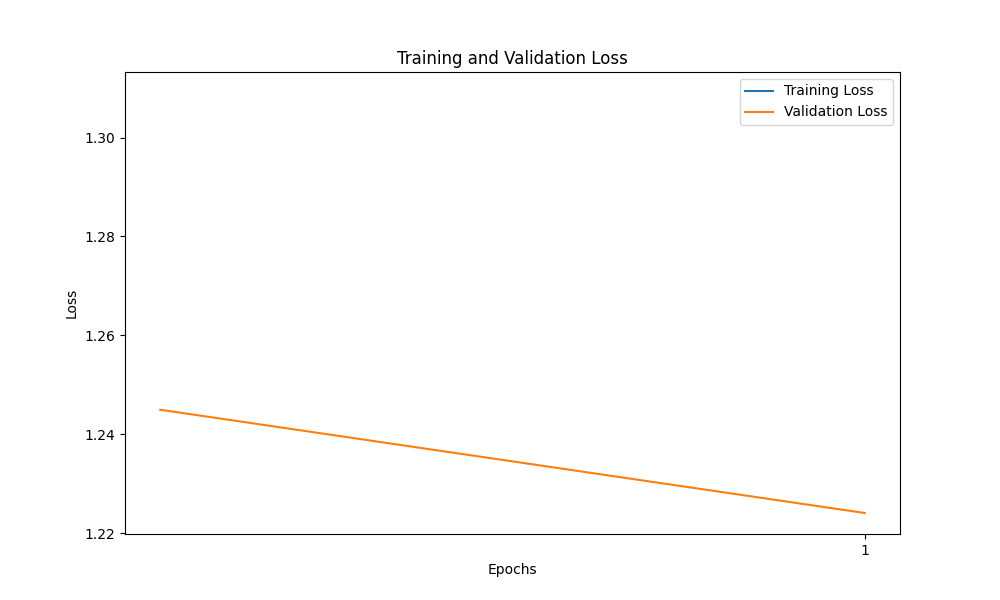

From the loss plot, it shows that the model are indeed trained to characterize emotions better.